In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [3]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

--2021-01-05 04:18:27--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  5.36MB/s    in 23s     

2021-01-05 04:18:50 (4.82 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [4]:
!unzip horse2zebra.zip

Archive:  horse2zebra.zip
   creating: horse2zebra/
   creating: horse2zebra/trainA/
  inflating: horse2zebra/trainA/n02381460_6223.jpg  
  inflating: horse2zebra/trainA/n02381460_1567.jpg  
  inflating: horse2zebra/trainA/n02381460_3354.jpg  
  inflating: horse2zebra/trainA/n02381460_299.jpg  
  inflating: horse2zebra/trainA/n02381460_3001.jpg  
  inflating: horse2zebra/trainA/n02381460_4242.jpg  
  inflating: horse2zebra/trainA/n02381460_1666.jpg  
  inflating: horse2zebra/trainA/n02381460_4396.jpg  
  inflating: horse2zebra/trainA/n02381460_4502.jpg  
  inflating: horse2zebra/trainA/n02381460_8527.jpg  
  inflating: horse2zebra/trainA/n02381460_14.jpg  
  inflating: horse2zebra/trainA/n02381460_706.jpg  
  inflating: horse2zebra/trainA/n02381460_4019.jpg  
  inflating: horse2zebra/trainA/n02381460_1478.jpg  
  inflating: horse2zebra/trainA/n02381460_3449.jpg  
  inflating: horse2zebra/trainA/n02381460_5558.jpg  
  inflating: horse2zebra/trainA/n02381460_969.jpg  
  inflating: horse2

In [3]:
!ls horse2zebra

testA  testB  trainA  trainB


In [4]:
import glob
path = ""
horses_train = glob.glob(path + 'horse2zebra/trainA/*.jpg')
zebras_train = glob.glob(path + 'horse2zebra/trainB/*.jpg')
horses_test = glob.glob(path + 'horse2zebra/testA/*.jpg')
zebras_test = glob.glob(path + 'horse2zebra/testB/*.jpg')

In [5]:
len(horses_train), len(zebras_train), len(horses_test), len(zebras_test)

(1067, 1334, 120, 140)

In [6]:
import cv2
for file in horses_train[:10]:
    img = cv2.imread(file)
    print (img.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Horses


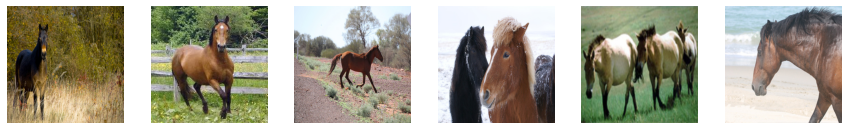

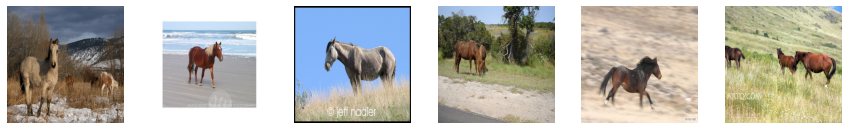

--------------------------------------------------------------------------------
Zebras


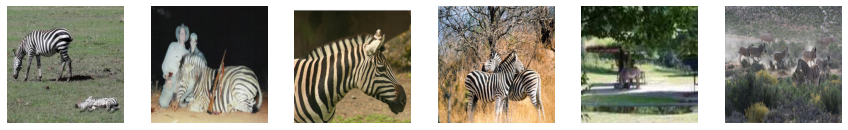

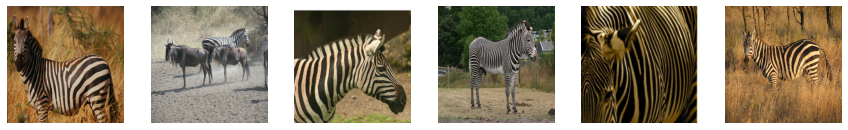

In [7]:
print ("Horses")
for k in range(2):
    plt.figure(figsize=(15, 15))
    for j in range(6):
        file = np.random.choice(horses_train)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(660 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Zebras")
for k in range(2):
    plt.figure(figsize=(15, 15))
    for j in range(6):
        file = np.random.choice(zebras_train)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(660 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (Res-Net Like)

In [8]:
#Taken from: https://keras.io/examples/generative/cyclegan/

class ReflectionPadding2D(tensorflow.keras.layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tensorflow.pad(input_tensor, padding_tensor, mode="REFLECT")

In [9]:
import tensorflow_addons as tfa

In [10]:
# Weights initializer for the layers.
kernel_init = tensorflow.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = tensorflow.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [11]:
# c7s1-64 ==> Conv block with `relu` activation, filter size of 7
# d128 ====|
#          |-> 2 downsampling blocks
# d256 ====|
# R256 ====|
# R256     |
# R256     |
# R256     |
# R256     |-> 9 residual blocks
# R256     |
# R256     |
# R256     |
# R256 ====|
# u128 ====|
#          |-> 2 upsampling blocks
# u64  ====|
# c7s1-3 => Last conv block with `tanh` activation, filter size of 7.


In [12]:
def custom_resnet_block(input_data, filters):
    x = ReflectionPadding2D()(input_data)
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(3,3), padding='valid', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)

    x = ReflectionPadding2D()(x)
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(3,3), padding='valid', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization()(x)

    x = tensorflow.keras.layers.Add()([x, input_data])
    return x

In [13]:
def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(256, 256, 3))

    x = ReflectionPadding2D(padding=(3, 3))(source_image)
    x = tensorflow.keras.layers.Conv2D(64, kernel_size=(7,7), kernel_initializer=kernel_init, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)

    x = tensorflow.keras.layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)

    x = tensorflow.keras.layers.Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)

    x = custom_resnet_block(x, 256)
    x = custom_resnet_block(x, 256)
    x = custom_resnet_block(x, 256)

    x = custom_resnet_block(x, 256)
    x = custom_resnet_block(x, 256)
    x = custom_resnet_block(x, 256)

    x = custom_resnet_block(x, 256)
    x = custom_resnet_block(x, 256)
    x = custom_resnet_block(x, 256)

    x = tensorflow.keras.layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), padding='same', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)

    x = tensorflow.keras.layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)

    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = tensorflow.keras.layers.Conv2D(3, kernel_size=(7,7), padding='valid')(x)
    x = tfa.layers.InstanceNormalization()(x)

    translated_image = tensorflow.keras.layers.Activation('tanh')(x)

    return source_image, translated_image

source_image, translated_image = make_generator()
generator_network_AB = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

source_image, translated_image = make_generator()
generator_network_BA = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)

print (generator_network_AB.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        reflection_padding2d[0][0]       
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
______________________________________________________________________________________________

# Discriminator Network

In [14]:
def my_conv_layer(input_layer, filters, strides, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=strides, padding='same', kernel_initializer=kernel_init)(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [15]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

    x = my_conv_layer(target_image_input, 64, (2,2), bn=False)
    x = my_conv_layer(x, 128, (2,2))
    x = my_conv_layer(x, 256, (2,2))
    x = my_conv_layer(x, 512, (1,1))

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network_A = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

target_image_input, patch_features = make_discriminator()
discriminator_network_B = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network_A.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
instance_normalization_48 (I (None, 64, 64, 128)       256       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 256)       5245

In [16]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network_A.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])
discriminator_network_B.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Cycle-GAN

In [17]:
source_image_A = tensorflow.keras.layers.Input(shape=(256, 256, 3))
source_image_B = tensorflow.keras.layers.Input(shape=(256, 256, 3))

# Domain Transfer
fake_B = generator_network_AB(source_image_A)
fake_A = generator_network_BA(source_image_B)

# Restoring original Domain
get_back_A = generator_network_BA(fake_B)
get_back_B = generator_network_AB(fake_A)

# Get back Identical/Same Image
get_same_A = generator_network_BA(source_image_A)
get_same_B = generator_network_AB(source_image_B)
  
discriminator_network_A.trainable=False
discriminator_network_B.trainable=False

# Tell Real vs Fake, for a given domain
verify_A = discriminator_network_A(fake_A)
verify_B = discriminator_network_B(fake_B)

cycle_gan = tensorflow.keras.models.Model(inputs = [source_image_A, source_image_B], \
                              outputs = [verify_A, verify_B, get_back_A, get_back_B, get_same_A, get_same_B])
cycle_gan.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  11388617    input_6[0][0]                    
                                                                 model[0][0]                      
                                                                 input_5[0][0]                    
____________________________________________________________________________________________

# Compiling Models

In [18]:
cycle_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], loss_weights=[1, 1, 10, 10, 5, 5],\
                                          optimizer=adam_optimizer)

# Define Data Generators

In [19]:
def horses_to_zebras(horses, generator_network):
    generated_samples = generator_network.predict_on_batch(horses)
    return generated_samples

def zebras_to_horses(zebras, generator_network):
    generated_samples = generator_network.predict_on_batch(zebras)
    return generated_samples

def get_horse_samples(batch_size):
    random_files = np.random.choice(horses_train, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img-127.5)/127.5)
    horse_images = np.array(images)
    return horse_images

def get_zebra_samples(batch_size):
    random_files = np.random.choice(zebras_train, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((img-127.5)/127.5)
    zebra_images = np.array(images)
    return zebra_images

def show_generator_results_horses_to_zebras(generator_network_AB, generator_network_BA):
    images = []
    for j in range(5):
        file = np.random.choice(horses_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Horse Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(550 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Horse -> Zebra) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = horses_to_zebras(np.array([img]), generator_network_AB)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(550 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse ( Fake Zebras -> Fake Horses)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = zebras_to_horses(np.array([img]), generator_network_BA)[0]
        output = (output+1.0)/2.0
        plt.subplot(550 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

def show_generator_results_zebras_to_horses(generator_network_AB, generator_network_BA):
    images = []
    for j in range(5):
        file = np.random.choice(zebras_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Zebra Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(550 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated (Zebra -> Horse) Images')
    translated = []
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = zebras_to_horses(np.array([img]), generator_network_BA)[0]
        translated.append(output)
        output = (output+1.0)/2.0
        plt.subplot(550 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Translated reverse (Fake Horse -> Fake Zebra)')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(translated):
        output = horses_to_zebras(np.array([img]), generator_network_AB)[0]
        output = (output+1.0)/2.0
        plt.subplot(550 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [20]:
len(horses_train), len(zebras_train)

(1067, 1334)

Input Horse Images


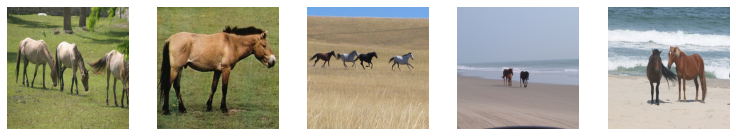

Translated (Horse -> Zebra) Images


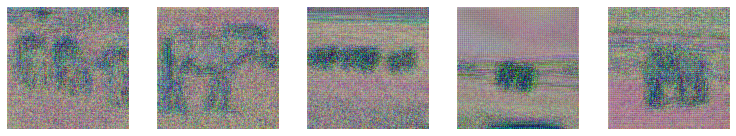

Translated reverse ( Fake Zebras -> Fake Horses)


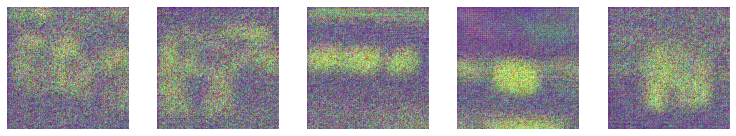

----------------------------------------------------------------------------------------------------
Input Zebra Images


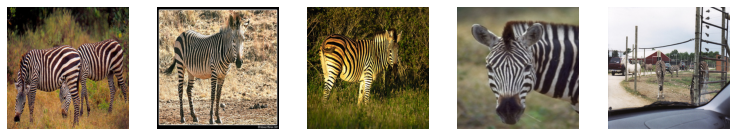

Translated (Zebra -> Horse) Images


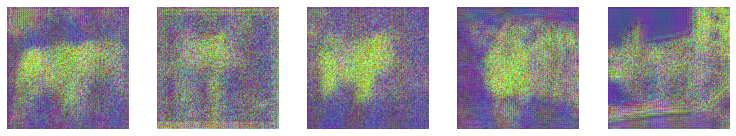

Translated reverse (Fake Horse -> Fake Zebra)


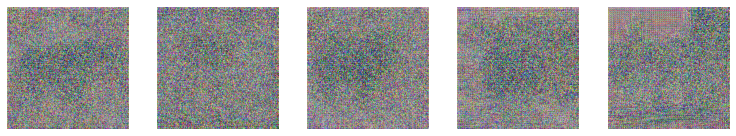

Epoch:0, Step:0, DA-Loss:2.480, DA-Acc:48.877, DB-Loss:2.316, DB-Acc:45.703, G-Loss:33.895
Epoch:0, Step:100, DA-Loss:0.265, DA-Acc:59.082, DB-Loss:0.309, DB-Acc:59.619, G-Loss:10.140


In [ ]:
epochs = 500
batch_size = 1
steps = 1067

for i in range(0, epochs):
    if i%5 == 0:
        show_generator_results_horses_to_zebras(generator_network_AB, generator_network_BA)
        print ("-"*100)
        show_generator_results_zebras_to_horses(generator_network_AB, generator_network_BA)
    for j in range(steps):  
        # A == Horses
        # B == Zebras
        domain_A_images = get_horse_samples(batch_size)
        domain_B_images = get_zebra_samples(batch_size)

        fake_patch = np.zeros((batch_size, 32, 32, 1))
        real_patch = np.ones((batch_size, 32, 32, 1))
        
        fake_B_images = generator_network_AB(domain_A_images)
        fake_A_images = generator_network_BA(domain_B_images)
        
        # Updating Discriminator A weights
        discriminator_network_A.trainable=True
        discriminator_network_B.trainable=False
        loss_d_real_A = discriminator_network_A.train_on_batch(domain_A_images, real_patch)
        loss_d_fake_A = discriminator_network_A.train_on_batch(fake_A_images, fake_patch)
        
        loss_d_A = np.add(loss_d_real_A, loss_d_fake_A)/2.0
        
        # Updating Discriminator B weights
        discriminator_network_B.trainable=True
        discriminator_network_A.trainable=False
        loss_d_real_B = discriminator_network_B.train_on_batch(domain_B_images, real_patch)
        loss_d_fake_B = discriminator_network_B.train_on_batch(fake_B_images, fake_patch)
        
        loss_d_B = np.add(loss_d_real_B, loss_d_fake_B)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network_A.trainable=False
        discriminator_network_B.trainable=False
        
        # Updating Generator weights
        loss_g = cycle_gan.train_on_batch([domain_A_images, domain_B_images],\
                    [real_patch, real_patch, domain_A_images, domain_B_images, domain_A_images, domain_B_images])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, DA-Loss:%.3f, DA-Acc:%.3f, DB-Loss:%.3f, DB-Acc:%.3f, G-Loss:%.3f"\
                   %(i,j,loss_d_A[0],loss_d_A[1]*100,loss_d_B[0],loss_d_B[1]*100,loss_g[0]))
            